# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

## Objective of the project

What is **not** our objective :

<img src="dog.png" alt="drawing" width="600"/>

In [1]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import normalize

Using TensorFlow backend.


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**2) Check the shape of images and targets.**

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [4]:
# labels = {
#     0: 'airplane',
#     1: 'automobile',
#     2: 'bird',
#     3: 'cat',
#     4: 'deer',
#     5: 'dog',
#     6: 'frog',
#     7: 'horse',
#     8: 'ship',
#     9: 'truck'
# }
labels = {
    0: 'iron birb',
    1: 'iron doggo',
    2: 'birb',
    3: 'catto',
    4: 'Tree doggo',
    5: 'doggo',
    6: 'froggo',
    7: 'giant doggo',
    8: 'iron fish',
    9: 'iron rhino'
}

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [5]:
x_train_norm = normalize(x_train, axis=3)
x_test_norm = normalize(x_test, axis=3)

In [6]:
print('Before :', x_train[1, :][0][0])
print('After :', x_train_norm[1, :][0][0])

Before : [154 177 187]
After : [0.51329341 0.58995412 0.62328486]


**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [7]:
y_train = to_categorical(y_train, num_classes=10, dtype=int)
y_test  = to_categorical(y_test, num_classes=10, dtype=int)

In [8]:
print(y_train[1:10])

[[0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]]


**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

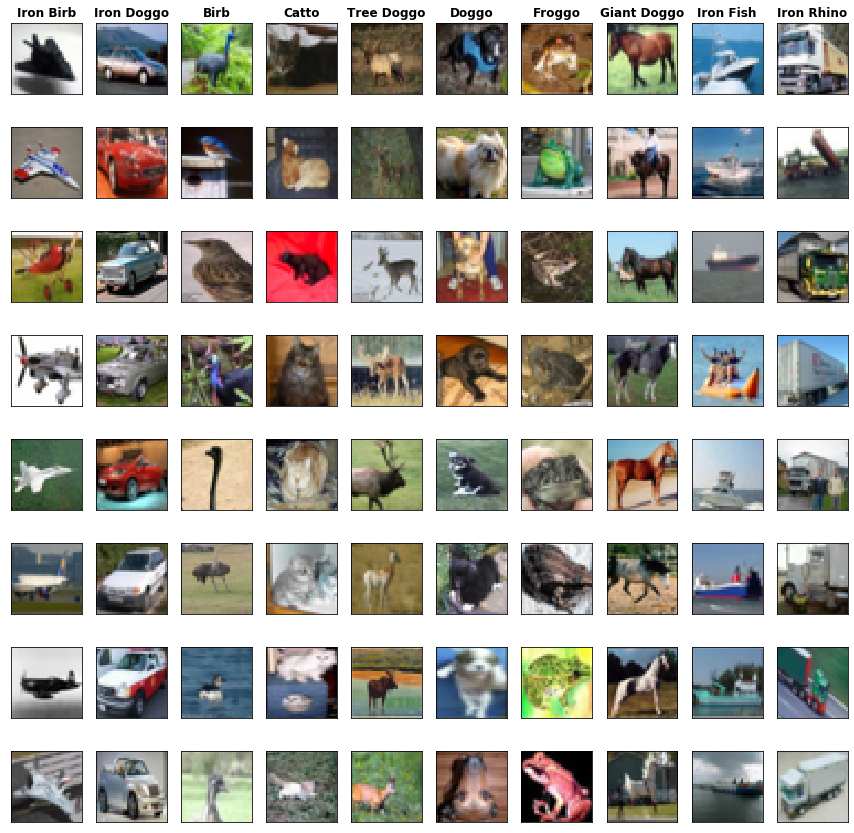

In [10]:
limit = 80
i = 1
count = 0
columns = 10
rows = 8
num_cat = np.repeat(0, 10)

fig=plt.figure(figsize=(15, 15))


while count < limit:
    index_image = i - 1
    category, = np.where(y_train[index_image] == 1.)[0]
    if num_cat[category] < 8:
        location = columns * num_cat[category] + category + 1
        sp = fig.add_subplot(rows, columns, location, xticks= [], yticks=[])
        if(num_cat[category] == 0):
            sp.set_title(labels[category].title(),fontweight="bold")
        num_cat[category] = num_cat[category] + 1
        plt.imshow(x_train[index_image, :])
        count += 1
    i += 1

The following code summarizes the previous operations. 

In [ ]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    labels = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
    labels = {
        0: 'iron birb',
        1: 'iron doggo',
        2: 'birb',
        3: 'catto',
        4: 'Tree doggo',
        5: 'doggo',
        6: 'froggo',
        7: 'giant doggo',
        8: 'iron fish',
        9: 'iron rhino'
    }
    x_train = normalize(x_train, axis=2)
    x_test = normalize(x_test, axis=2)
    
    y_train = to_categorical(y_train, num_classes=10, dtype=int)
    y_test  = to_categorical(y_test, num_classes=10, dtype=int)

    return x_train, y_train, x_test, y_test, labels


x_train, y_train, x_test, y_test, labels = load_cifar_data()


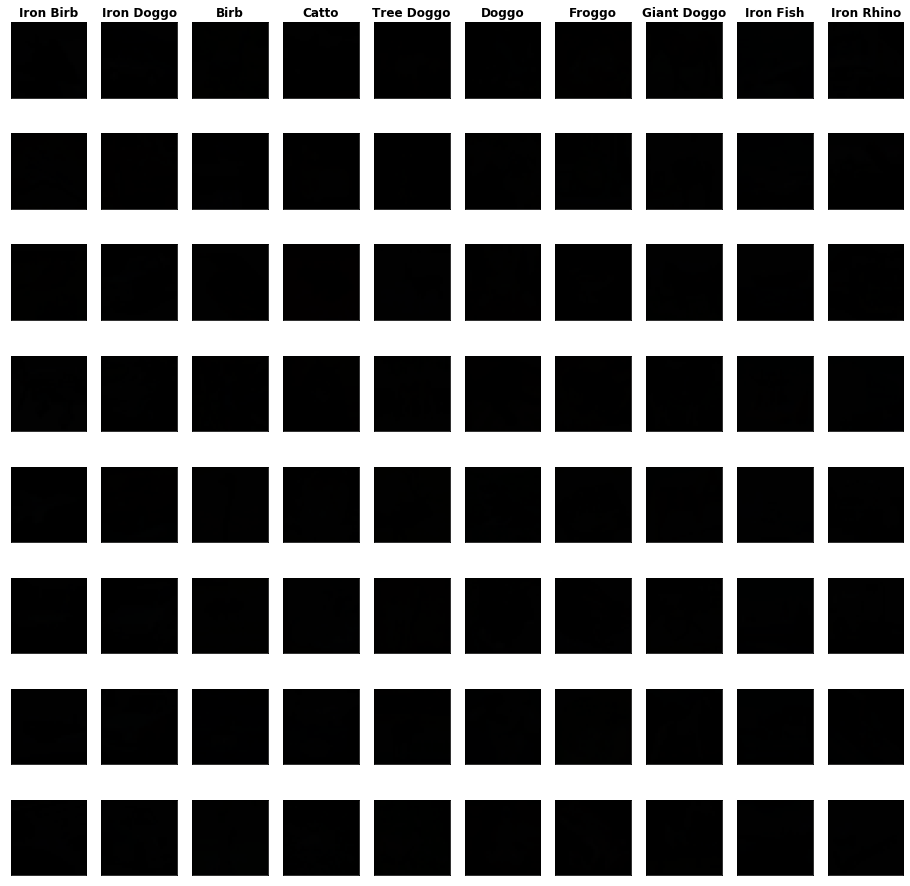

In [70]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    
    columns = 10
    rows = n
    
    limit = n * columns

    i = 1
    count = 0
    
    num_cat = np.repeat(0, 10)

    fig=plt.figure(figsize=(2 * n, 2 * n))

    while count < limit:
        index_image = i - 1
        if isinstance(categories[index_image], int):
            category = categories[index_image]
        else:
            category, = np.where(categories[index_image] == 1.)[0]
        if num_cat[category] < 8:
            location = columns * num_cat[category] + category + 1
            sp = fig.add_subplot(rows, columns, location, xticks= [], yticks=[])
            if(num_cat[category] == 0):
                sp.set_title(labels[category].title(),fontweight="bold")
            num_cat[category] = num_cat[category] + 1
            plt.imshow(images[index_image, :])
            count += 1
        i += 1
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)



<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [13]:
def dense_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='linear'))

    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
dense_mod = dense_model(x_train.shape[1:], 10)
dense_mod.build()

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

The dimension of the flattened data is `32 x 32 x 3 = 3072` 

Then, the numbers of parameters for the first layer is : `(3072 + 1) x 2048 = 6293504`

For the second layer, we have `(2048 + 1) x 1024 = 2098176` parameters.

For the third layer, we have `(1024 + 1) x 512 = 524800` parameters.

For the fourth layer, we have `(512 + 1) x 256 = 131328` parameters.

For the fifth layer, we have `(256 + 1) x 10 = 2570` parameters.

If we sum all the parameters, we obtain a total of `6293504 + 2098176 + 524800 + 131328 + 2570 = 9050378` parameters.

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [15]:
dense_mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
____________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [45]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    cb = EarlyStopping(monitor='accuracy', patience=0)
    model.fit(x, y, batch_size=batch_size, epochs=epochs, callbacks=[cb], validation_split=0.2)
    
    return model

In [46]:
dense_mod = train_model(dense_mod, x_train, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 76s 2ms/step - loss: 9.8270 - accuracy: 0.1003 - val_loss: 9.5741 - val_accuracy: 0.0980
Epoch 2/10
40000/40000 [==============================] - 76s 2ms/step - loss: 9.6950 - accuracy: 0.1005 - val_loss: 9.5741 - val_accuracy: 0.0980
Epoch 3/10
40000/40000 [==============================] - 77s 2ms/step - loss: 9.6950 - accuracy: 0.1005 - val_loss: 9.5741 - val_accuracy: 0.0980


In [47]:
dense_mod.save('./naive_model')

**11) Plot several images with their predictions. Any comment?**

In [59]:
naive_pred_labels = dense_mod.predict(x_test).argmax(axis = -1)

In [60]:
np.bincount(naive_pred_labels)

array([    0,     0,     0,     0,     0,     0, 10000])

In [51]:
def plot_n_first_pred(pred, n=10):
    col_legend = ['red', 'green']
    fig=plt.figure(figsize=(10, 10))
    for i in range(n):
        sp = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        cond = int(pred[i] == y_test[i].argmax())
        col = col_legend[cond]
        sp.set_title(labels[pred[i]].title(),fontweight="bold", color=col)
        plt.imshow(x_test[i, :], )

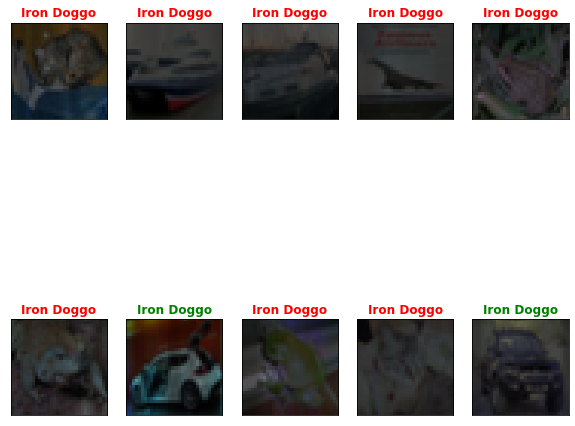

In [52]:
plot_n_first_pred(naive_pred_labels)

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [19]:
def cnn_model2(input_shape, num_classes):
    
    model = Sequential()
    
    model.add(Conv2D(
        filters=32,
        kernel_size=3, 
        padding='same',
        activation='relu',
        input_shape=input_shape,
        name = 'Conv1'
    ))
    model.add(Conv2D(
        filters=32,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv2'
    ))
    model.add(MaxPooling2D(name = 'MaxPool1'))
    model.add(Conv2D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv3'
    ))
    model.add(Conv2D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv4'
    ))
    model.add(MaxPooling2D(name='MaxPool2'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(512, activation='relu', name = 'Dense1'))
    model.add(Dense(num_classes, activation='softmax', name='Dense2'))

    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [20]:
cnn_model = cnn_model2(x_train.shape[1:], 10)
cnn_model.build()

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

For every convolutional layer, the number of parameters is equal to :

`(number of channels (3) x dimension of the kernel + biais (1)) x number of feature maps)`

The number of parameters thus is :

- 1st convolutional layer : `(3 x 9 + 1) x 32 = 896` parameters.
- 2nd convolutional layer : `(32 x 9 + 1) x 32 = 9248` parameters.
- 1st pooling layer `0` parameters. (makes the output `15 x 15`)
- 3rd convolutional layer : `(32 x 9 + 1) x 64 = 18496` parameters.
- 4th convolutional layer : `(64 x 9 + 1) x 64 = 36928` parameters.
- 2nd pooling layer `0` parameters. (makes the output `5 x 5`)
- 1st flatten layer `0` parameters. (flattens `64 x 5 x 5` to `1600 x 1`)
- 1st dense layer `(1600 + 1) x 512 = 819712` parameters.
- 1st dense layer `(512 + 1) x 10 = 5130` parameters.

The total number of parameters is then :
`896 + 9248 + 18496 + 36928 + 819712 + 5130 = 890410` parameters in total.

There are fewer parameters than the simple dense network because we **progressively reduce the size** of the input by using **convolution** and **pooling**.

In [21]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 15, 15, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 11, 11, 64)        36928     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 5, 5, 64)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 1600)             

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [65]:
cnn_model = train_model(cnn_model, x_train, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 94s 2ms/step - loss: 2.0304 - accuracy: 0.2702 - val_loss: 1.9013 - val_accuracy: 0.3210
Epoch 2/10
40000/40000 [==============================] - 95s 2ms/step - loss: 1.8286 - accuracy: 0.3479 - val_loss: 1.7491 - val_accuracy: 0.3793
Epoch 3/10
40000/40000 [==============================] - 95s 2ms/step - loss: 1.7000 - accuracy: 0.3963 - val_loss: 1.6655 - val_accuracy: 0.4052
Epoch 4/10
40000/40000 [==============================] - 96s 2ms/step - loss: 1.6011 - accuracy: 0.4310 - val_loss: 1.5762 - val_accuracy: 0.4399
Epoch 5/10
40000/40000 [==============================] - 96s 2ms/step - loss: 1.5156 - accuracy: 0.4659 - val_loss: 1.5470 - val_accuracy: 0.4529
Epoch 6/10
40000/40000 [==============================] - 96s 2ms/step - loss: 1.4350 - accuracy: 0.4991 - val_loss: 1.4783 - val_accuracy: 0.4761
Epoch 7/10
40000/40000 [==============================] - 96s 2ms/st

In [66]:
cnn_model.save('./cnn_model')

In [67]:
cnn_pred_labels = cnn_model.predict(x_test)
print(cnn_pred_labels[0:10,])
cnn_pred_labels = cnn_pred_labels.argmax(axis = 1)
print(cnn_pred_labels[0:10,])
print(np.bincount(cnn_pred_labels))

[[7.12295109e-03 1.09283905e-03 2.89298475e-01 1.09639302e-01
  2.60090798e-01 3.77336480e-02 2.87086219e-01 5.97400358e-03
  1.68593810e-03 2.75730970e-04]
 [3.91129434e-01 2.42924154e-01 4.38842137e-04 5.55823171e-05
  2.75736238e-04 6.95840254e-06 3.58756261e-05 1.51570075e-05
  2.98513860e-01 6.66043311e-02]
 [1.84446752e-01 4.01967257e-01 7.31807761e-03 4.77803126e-03
  2.07762793e-02 8.74266587e-03 1.12087140e-03 9.47783235e-03
  2.29693979e-01 1.31678298e-01]
 [6.50614977e-01 2.57138591e-02 9.15015936e-02 6.43097912e-04
  4.83124442e-02 2.39697678e-04 3.17438226e-03 5.36422152e-03
  1.72673970e-01 1.76172517e-03]
 [1.91146042e-03 4.97608155e-04 5.58341965e-02 4.73642260e-01
  5.21519259e-02 1.01782575e-01 3.12041700e-01 1.09173800e-03
  8.54655867e-04 1.91940941e-04]
 [3.18242162e-02 2.01908965e-03 2.21699327e-01 2.21895985e-02
  6.63674623e-02 1.57155227e-02 6.15069509e-01 3.12443683e-03
  2.14028023e-02 5.87972521e-04]
 [1.58833336e-05 1.05196457e-04 6.06253892e-02 1.26368611e

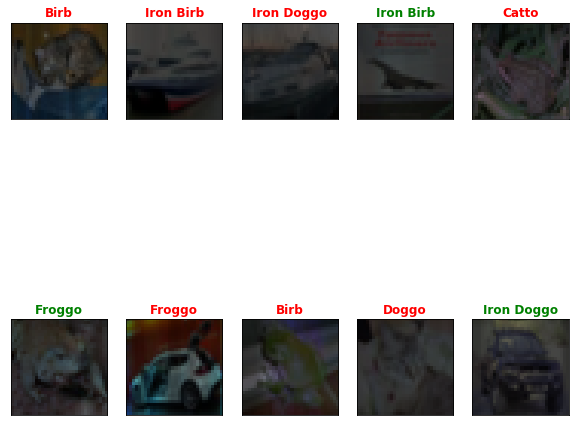

In [68]:
plot_n_first_pred(cnn_pred_labels)

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [11]:
######################
# TO DO

# END TO DO 
######################

In [12]:
######################
# TO DO

# END TO DO 
######################

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

In [13]:
######################
# TO DO

# END TO DO 
######################

In [14]:
######################
# TO DO


# END TO DO 
######################

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [15]:
######################
# TO DO

# END TO DO 
######################

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

In [16]:
######################
# TO DO

def predict(model, x, labels, file_name=None):
    
    
    
    
    
    
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

predict(model, x_test[3:8,:,:,:], labels, file_name="predictions.png")


# END TO DO 
######################

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [17]:
######################
# TO DO

...


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    ...
    
    




# END TO DO 
######################

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks (Bonus !)

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [18]:
###########################
# TO DO 

# END TO DO 
##################

In [19]:
###########################
# TO DO 

# END TO DO 
##################

In [20]:
###########################
# TO DO 

# END TO DO 
##################

In [21]:
##################
# TO DO 


# END TO DO 
##################